In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import json
import string
from fractions import Fraction
from collections import defaultdict
import apriori

In [3]:
f = open('recipeitems-latest.json', 'r')
lines = f.readlines()
f.close()
recipes = []
for line in lines:
    recipe = json.loads(line)
    recipes.append(recipe)


In [4]:
allingredients = []
allnames = []
for recipe in recipes:
    name = recipe['name']
    ingredients = recipe['ingredients'].split('\n')
    allingredients.extend(ingredients)
    for i in ingredients:
        allnames.append(name)

In [5]:
empty_words = ['freerange', 'organic', 'ripe', 'freshly', 'dried', 'fresh', 'thin', 'thick', 'chopped',
               'ground', 'cooked', 'kosher', 'cut', 'into', 'wedges', 'diced', 'trimmed', 'grated',
               'halved', 'lengthwise', 'and', 'pieces', 'medium', 'peeled', 'grated', 'thinkly', 'sliced',
              'quartered', 'good-quality', 'good', 'quality']

In [6]:
iwords = ['cup', 'teaspoon', 'tablespoons', 'cups', 'whole', 'tablespoon', 'teaspoons', 'ounces', 'tbsp', 'tsp',
 'large', 'pound', 'can', 'pinch', 'pounds', 'tbs', 'medium', 'small', 'slices', 'package', 'bunch', 'g',
 'dash', 'lb', 'oz', 'stick', 'cans', 'fl', 'sprigs', 'stalks', 'box', 'ounce', 'pieces', 'fluid', 'sticks',
 'pint', 'bag', 'dashes', 'jar', 'quart', 'pinches', 'ml', 'packages', 'quarts', 'grams', 'sprig',
 'drops', 'tb', 'stalk', 'bottle', 'handful', 'c', 'strips', 'container', 'bunches', 'cubes', 'slice', 'heads',
 'handfuls', 'piece', 'milliliters', 't', 'kg', 'pints', 'lbs', 'cube', 'gallon', 'bulb', 'block', 'boxes',
 'packet', 'jars']

In [7]:
confirmed_measurement_terms = defaultdict(int)
filter_map = defaultdict(int)

for word in empty_words:
    filter_map[word] = 1

for word in iwords:
    confirmed_measurement_terms[word] = 1

In [8]:
def get_numeric(x):
    x = x.replace('~', '')
    x = x.replace('?', '0')
    try:
        amt = float(sum(Fraction(s) for s in x.split()))
        return amt
    except ValueError:
        arr = x.split('-')
        if len(arr)==2:
            try:
                amt1 = float(sum(Fraction(s) for s in arr[0].split()))
                amt2 = float(sum(Fraction(s) for s in arr[1].split()))
                return amt1 + amt2
            except ValueError:
                return -1
        return -1

In [9]:
def remove_parenthesis_content(x):
    i = x.find('(')
    if i == -1:
        return x
    j = x.find(')', i)
    if j == -1:
        return x
    return x[0:i] + x[(j+1):len(x)]

In [10]:
unmatched = []
raw = []
names = []
measures = defaultdict(int)
pingredients = []
measurel = []
amts = []

for ingredient, name in zip(allingredients, allnames):
    oingredient = ingredient
    i = 0
    ingredient = ingredient.replace(',', ' ').encode('ascii', 'replace')
    ingredient = remove_parenthesis_content(ingredient)
    terms = ingredient.lower().strip().replace('\t', ' ').replace('/', ' ').split(' ')
    terms = [term.strip() for term in terms]
    try:
        terms.remove('')
    except ValueError:
        i=0
    tamt = 0
    amt = 0
    while i < len(terms) and amt >= 0:
        amt = get_numeric(terms[i])
        if amt != -1:
            tamt += amt
            i += 1
    measure = ''
    c = 1
    ing = ''
    while i < len(terms) and c > 0:
        c = confirmed_measurement_terms[terms[i]]
        if c > 0:
            measure += terms[i] + ' '
            i += 1
    ing = ''
    j = i
    while i < len(terms):
        c2 = filter_map[terms[i]]
        if c2 == 0:
            if len(ing) > 0:
                ing += ' ' + terms[i]
            else:
                ing += terms[i]
        i+=1
    if tamt == 0:
        tamt = 1.0
    if ' '.join(terms[0:j]) != ing:
        #print tamt, '|', measure, '|', ing, '|', ingredient
        amts.append(tamt)
        pingredients.append(ing)
        measurel.append(measure)
        raw.append(oingredient)
        names.append(name)

df = pd.DataFrame({'raw': raw, 'name': names, 'ingredient': pingredients, 'amount': amts, 'measurement': measurel})
df['ingredient'] = df['ingredient'].apply(lambda x: x.encode('ascii', 'replace'))
df.head()

,amount,ingredient,measurement,name,raw
0,1,biscuits,,Drop Biscuits and Sausage Gravy,Biscuits
1,3,all-purpose flour,cups,Drop Biscuits and Sausage Gravy,3 cups All-purpose Flour
2,2,baking powder,tablespoons,Drop Biscuits and Sausage Gravy,2 Tablespoons Baking Powder
3,3,salt,teaspoon,Drop Biscuits and Sausage Gravy,1/2 teaspoon Salt
4,4,cold butter,stick,Drop Biscuits and Sausage Gravy,"1-1/2 stick (3/4 Cup) Cold Butter, Cut Into Pi..."


In [11]:
df.to_csv('recipes.csv', sep='\t', index=False, encoding='utf-8')

(0, 10)

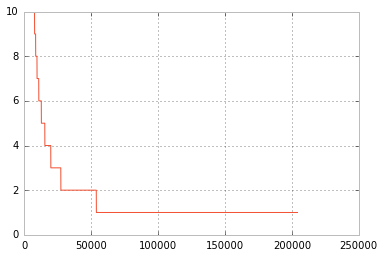

In [12]:
gp = pd.DataFrame(df.groupby(['ingredient'])['amount'].count())
gp.sort('amount', inplace=True, ascending=0)
plt.plot(gp.amount)
plt.ylim([0, 10])

In [13]:
gp.amount.mean()

5.8387741407769127